In [365]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from graphviz import Digraph
%matplotlib inline

In [367]:
def f(x):
    return 3*x**2 -4*x + 5

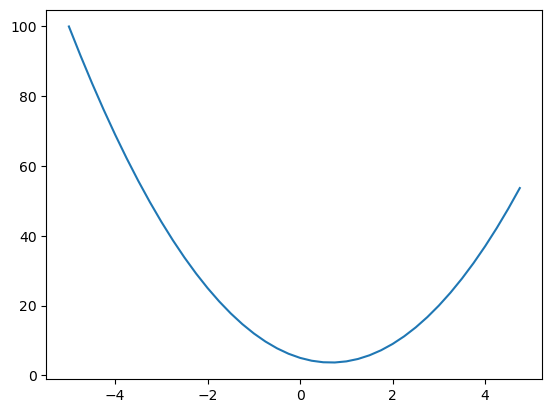

In [369]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [371]:
class Value:

    def __init__(self,data, _children =(), _op = "", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), "+") 

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out
        
    def __pow__(self,other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,) ,f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        
        out._backward = _backward

        return out
        
    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other) 

    def __radd__(self, other):
        return self + other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,_children=(self,), _op = "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad # out.grad = 1.0

        out._backward = _backward

        return out

    def exp(self):
        t = self.data
        out = Value(math.exp(t),_children=(self,),label="exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for i in v._prev:
                    build_topo(i)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [373]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [375]:
def lol():
    h = 0.00001
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    
    e = a * b; e.label = "e"
    e.data += h
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data

    print((L2-L1)/h)

In [377]:
lol()

-1.9999999999242843


In [379]:
#inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
#weights
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
#bias
b = Value(6.8813735870195432,label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label = "o"
o.backward()

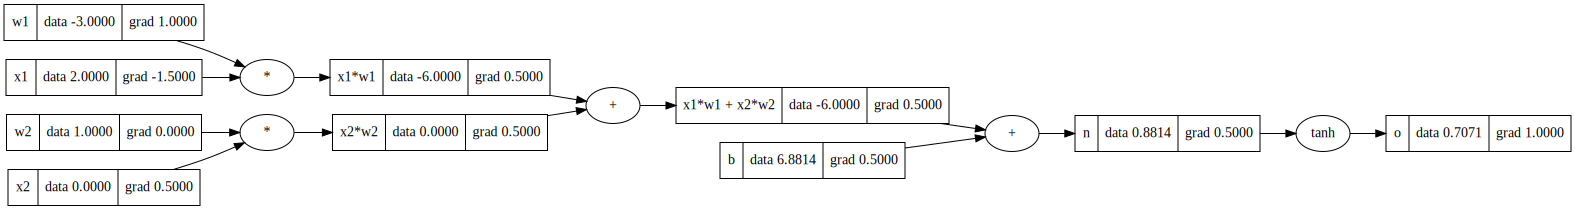

In [381]:
draw_dot(o)

In [383]:
#inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
#weights
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
#bias
b = Value(6.8813735870195432,label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
#----
e = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1); o.label = "o"
#----
o.backward()

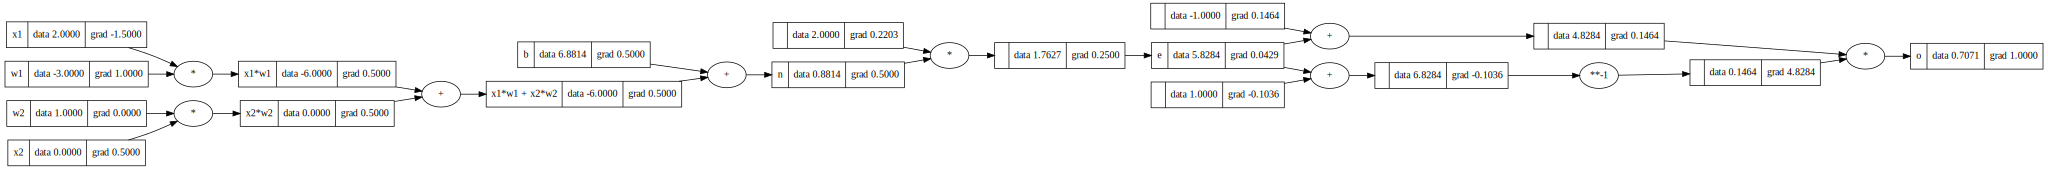

In [385]:
draw_dot(o)

In [387]:
#implementing topo sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for i in v._prev:
            build_topo(i)
        topo.append(v)
build_topo(o)
topo

[Value(data=2),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

In [389]:
for node in reversed(topo):
    node._backward()

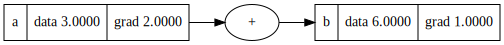

In [391]:
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

In [392]:
a + 1

Value(data=4.0)

In [395]:
2 * a

Value(data=6.0)

In [424]:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        out = sum((w1*x1 for w1,x1 in zip(self.w,x)),self.b)
        act = out.tanh()
        return act

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:

    def __init__(self,nin,nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nout))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [484]:
x = [2.0,3.0,-1.0]
a = MLP(3,[4,4,1])
a(x)

Value(data=-0.20922867378983423)

In [486]:
a.parameters()

[Value(data=0.4592058257451612),
 Value(data=-0.5072251993308212),
 Value(data=-0.13487281188535039),
 Value(data=-0.7693630924959014),
 Value(data=-0.8154368019137881),
 Value(data=0.19413117940138558),
 Value(data=-0.5521488487920034),
 Value(data=0.9844652385596475),
 Value(data=-0.11557279821702116),
 Value(data=0.12600880922141422),
 Value(data=-0.9168959240769161),
 Value(data=-0.8457059679202279),
 Value(data=-0.0063516775737773035),
 Value(data=0.7417467120197723),
 Value(data=0.3446204967868689),
 Value(data=-0.4058748283095992),
 Value(data=0.6394340138705581),
 Value(data=-0.07316939433846703),
 Value(data=0.04935922211317423),
 Value(data=0.5535940198306637),
 Value(data=-0.8564529295012153),
 Value(data=-0.25234325663644963),
 Value(data=-0.29486612057425887),
 Value(data=0.740013009079205),
 Value(data=0.006680190200137881),
 Value(data=-0.8389983590735783),
 Value(data=0.23499583143924418),
 Value(data=-0.5771316484937994),
 Value(data=-0.5086924024616424),
 Value(data=-

In [488]:
xs = np.random.randn(4,3)
ys = [1.0,-1.0,-1.0,1.0]
xs

array([[ 0.32931834, -0.11679181,  1.17638361],
       [-0.35896027,  2.50773608, -1.20247611],
       [-0.06257918,  0.25930787,  0.01039051],
       [-0.51589886, -0.01809146,  0.39368163]])

In [502]:
epochs = 100
loss_data = []
epochs_data = []
for k in range(epochs):

    # forward pass
    ypred = [a(x) for x in xs]
    loss = sum((yout - yp)**2 for yp,yout in zip(ys,ypred))

    #backward pass
    for p in a.parameters():
        p.grad = 0.0
    loss.backward()

    #update the parameters
    for p in a.parameters():
        p.data += -0.001 * p.grad    
    epochs_data.append(k)
    loss_data.append(loss.data)
    print("epochs :",k,"loss :", loss.data)

epochs : 0 loss : 2.4093412334117614
epochs : 1 loss : 2.4074235807723463
epochs : 2 loss : 2.4055097501987346
epochs : 3 loss : 2.4035996522106777
epochs : 4 loss : 2.401693198408907
epochs : 5 loss : 2.399790301457735
epochs : 6 loss : 2.397890875067951
epochs : 7 loss : 2.3959948339799984
epochs : 8 loss : 2.3941020939474322
epochs : 9 loss : 2.392212571720651
epochs : 10 loss : 2.390326185030895
epochs : 11 loss : 2.3884428525745225
epochs : 12 loss : 2.386562493997535
epochs : 13 loss : 2.384685029880371
epochs : 14 loss : 2.38281038172295
epochs : 15 loss : 2.3809384719299698
epochs : 16 loss : 2.379069223796446
epochs : 17 loss : 2.377202561493502
epochs : 18 loss : 2.375338410054389
epochs : 19 loss : 2.3734766953607527
epochs : 20 loss : 2.3716173441291195
epochs : 21 loss : 2.369760283897622
epochs : 22 loss : 2.367905443012943
epochs : 23 loss : 2.366052750617479
epochs : 24 loss : 2.36420213663673
epochs : 25 loss : 2.3623535317668933
epochs : 26 loss : 2.3605068674626724
e

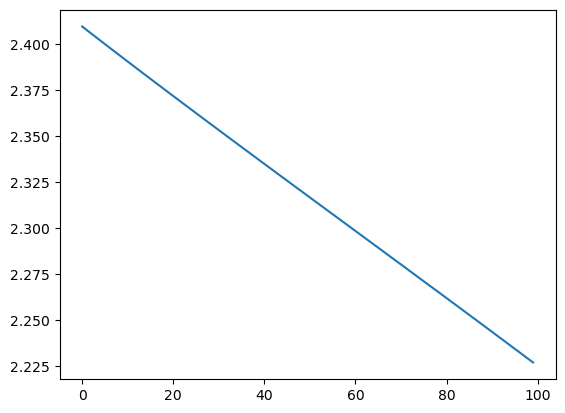

In [504]:
plt.plot(epochs_data,loss_data)